## Imports and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import acf, plot_acf, pacf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch
import warnings
warnings.filterwarnings("ignore")

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import holidays
import datetime

In [2]:
by_days = pd.read_pickle('sales_by_day.pkl')
by_days.head()

order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
Name: total_price, dtype: float64

In [3]:
by_days.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 365 entries, 2015-01-01 to 2015-12-31
Series name: total_price
Non-Null Count  Dtype  
--------------  -----  
365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


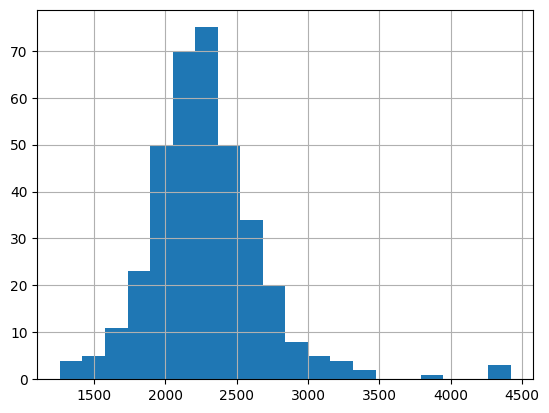

In [4]:
# View the histogram of sales to get a sense of the distribution of the sample.
by_days.hist(bins = 20)
plt.show()

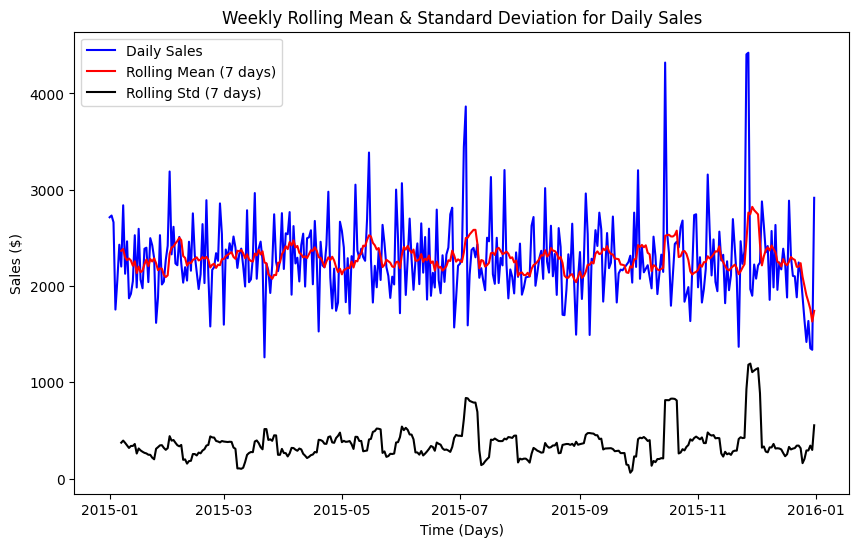

In [5]:
# Line plot of the total daily sales for the whole range of data: the year of 2015
# Also included is the rolling average of sales and the rolling standard deviation of sales taken over a moving one week window
rolmean = by_days.rolling(window = 7).mean()
rolstd = by_days.rolling(window = 7).std()

fig = plt.figure(figsize=(10, 6))
orig = plt.plot(by_days, color='blue',label='Daily Sales')
mean = plt.plot(rolmean, color='red', label='Rolling Mean (7 days)')
std = plt.plot(rolstd, color='black', label = 'Rolling Std (7 days)')
plt.legend(loc='best')
plt.title('Weekly Rolling Mean & Standard Deviation for Daily Sales')
plt.xlabel('Time (Days)')
plt.ylabel('Sales ($)')
plt.show()

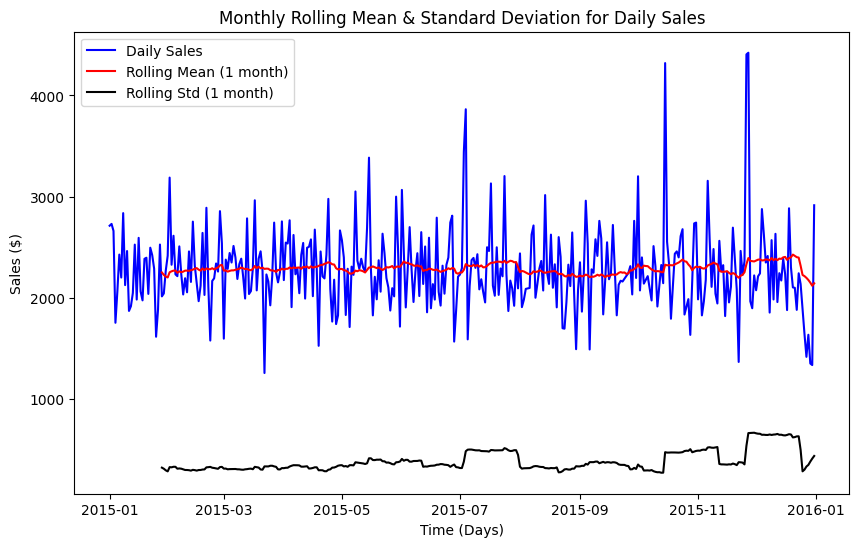

In [6]:
# Look at the above but with a rolling window of 28 days
rolmean = by_days.rolling(window = 28).mean()
rolstd = by_days.rolling(window = 28).std()

fig = plt.figure(figsize=(10, 6))
orig = plt.plot(by_days, color='blue',label='Daily Sales')
mean = plt.plot(rolmean, color='red', label='Rolling Mean (1 month)')
std = plt.plot(rolstd, color='black', label = 'Rolling Std (1 month)')
plt.legend(loc='best')
plt.title('Monthly Rolling Mean & Standard Deviation for Daily Sales')
plt.xlabel('Time (Days)')
plt.ylabel('Sales ($)')
plt.show()

To model a time series with the ARIMA family of models, you must determine certain orders to pass into the ARIMA function. These orders include integers for the autoregressive (AR) and moving average (MA) components of the ARIMA model. To determine those, we examine the autocorrelation function, partial autocorrelation function, and seasonal decomposition plots.

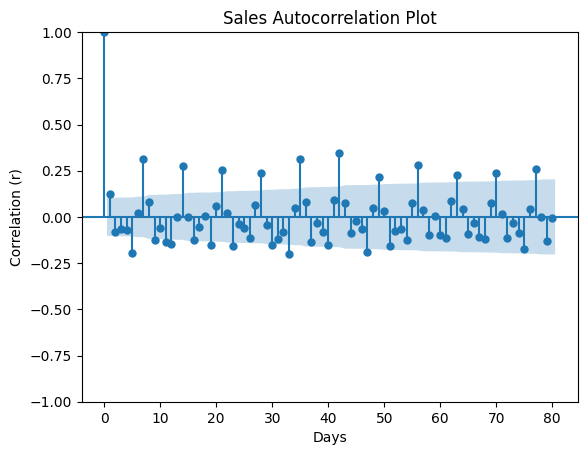

In [7]:
# Autocorrelation for data downsampled to daily. See up to 25 days
plot_acf(by_days, lags = 80)
plt.xlabel('Days')
plt.ylabel('Correlation (r)')
plt.title('Sales Autocorrelation Plot')
plt.show()

In [8]:
(np.sort(acf(by_days, nlags=80))[::-1] * 100).round(1)

array([100. ,  34.7,  31.6,  31.3,  28.3,  27.8,  26.2,  25.2,  24. ,
        23.9,  22.5,  21.8,  12.5,   8.9,   8.5,   8.2,   8. ,   7.7,
         7.5,   7.4,   6.6,   5.7,   5.1,   5. ,   4.4,   4.3,   3.8,
         3.2,   2.2,   2.1,   1.4,   0.4,   0.4,   0.1,  -0. ,  -0.2,
        -0.8,  -2. ,  -3.1,  -3.3,  -3.3,  -3.8,  -4.3,  -5.7,  -6.1,
        -6.2,  -6.3,  -6.5,  -6.6,  -6.8,  -7.6,  -8.1,  -8.2,  -8.4,
        -8.7,  -8.7,  -9.3,  -9.6, -10. , -10.9, -11.1, -11.5, -11.6,
       -11.8, -12. , -12.3, -12.3, -12.6, -12.9, -13.4, -13.7, -14.6,
       -15. , -15.3, -15.4, -15.6, -15.9, -17.2, -19.2, -19.7, -20.1])

We see a sharp drop after day one. The first value of an autocorrelation plot will always be 1, of course, as the first value has 100% correlation with itself. After that the autocorrelation drops below the band of statistical significance except for every 7 days and questionably every 5 days. What this is suggesting is that values in one week periods after the first value have a decent degree of autocorrelation with the first value (about +/- 30% to 20%). Or, in other words, you may be able to predict today's sales from the sales one week ago, or two weeks ago, or three weeks ago, etc. Next we look at the partial autocorrelation plots.

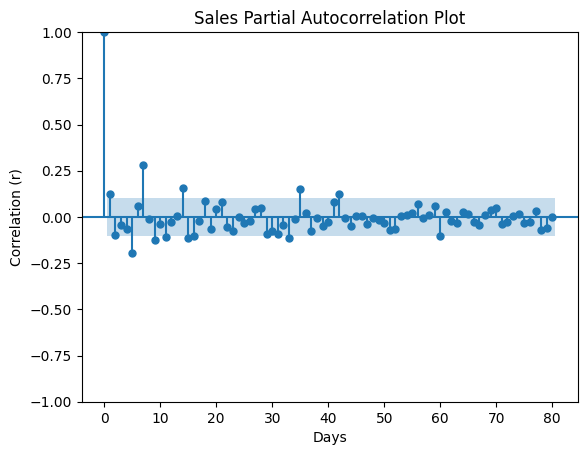

In [9]:
# Partial autocorrelation for data downsampled to daily. See out to 80 days
plot_pacf(by_days, lags = 80)
plt.xlabel('Days')
plt.ylabel('Correlation (r)')
plt.title('Sales Partial Autocorrelation Plot')
plt.show()

In [10]:
(np.sort(pacf(by_days, nlags=80))[::-1] * 100).round(1)

array([100. ,  28.6,  17.8,  16.4,  16.2,  12.6,  10.4,   9.9,   9.3,
         9. ,   7.9,   6.9,   6.3,   6.1,   6.1,   5.4,   4.7,   4.7,
         3.6,   3.6,   2.3,   1.9,   1.3,   0.5,   0.5,   0.5,   0.4,
         0.4,   0.4,   0.2,   0.1,   0. ,  -0.1,  -0.2,  -0.2,  -0.7,
        -0.8,  -0.9,  -1. ,  -1. ,  -1.1,  -1.3,  -2.1,  -2.2,  -2.2,
        -2.7,  -2.9,  -3.7,  -3.7,  -4. ,  -4.1,  -4.3,  -4.4,  -4.4,
        -4.5,  -5. ,  -5.2,  -5.6,  -5.7,  -6.1,  -6.4,  -6.8,  -7. ,
        -7.2,  -7.7,  -8.5,  -8.7,  -9.4,  -9.6,  -9.9,  -9.9, -10.1,
       -10.3, -10.6, -11. , -11.4, -12.2, -12.9, -13. , -13. , -19.8])

Partial autocorrelation functions (pacf) differ from autocorrelation functions in that the intervening days between a day and any other day are not considered in the correlation calculation. To clarify, when the normal autocorrelation (acf) above was found to be around 20 to 30% for each seven day period, those seven days periods were also considering day 2, 3, 4, 5, and 6. In a partial autocorrelation function, these intervening days are not considered. Again, the correlation is not better than about 30% and only after the first seven day period. 

Lastly, we take a look at the acf and pacf plots for the rolling 7 day variance of our daily sales. Mostly out of curiosity.

In [11]:
as_df = pd.DataFrame(by_days) # Change series to dataframe to use .rolling() method
roller = as_df.rolling(window = 7) # Create the rolling object with 7 day window
rolling_var = roller.var().dropna() # Apply variance function and drop null values

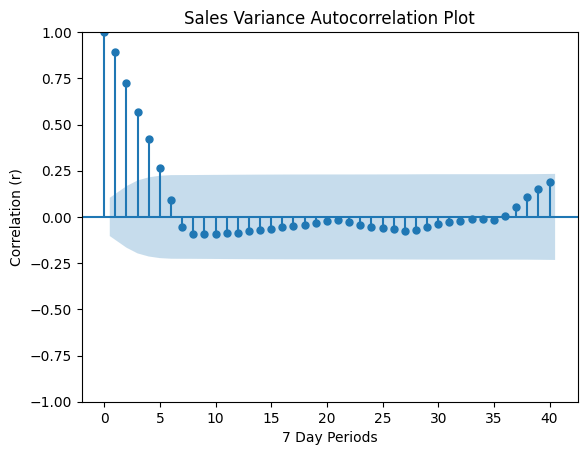

In [12]:
# Autocorrelation for variance in seven day rolling windows. See up to 40 one week periods
plot_acf(rolling_var, lags = 40)
plt.xlabel('7 Day Periods')
plt.ylabel('Correlation (r)')
plt.title('Sales Variance Autocorrelation Plot')
plt.show()

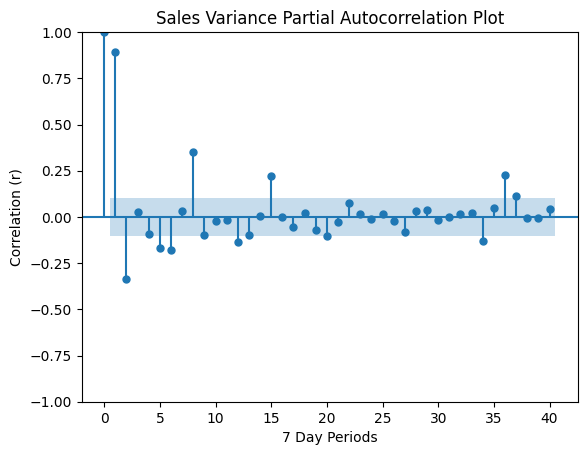

In [13]:
# Parital autocorrelation for variance in seven day rolling windows. See up to 40 one week periods
plot_pacf(rolling_var, lags = 40)
plt.xlabel('7 Day Periods')
plt.ylabel('Correlation (r)')
plt.title('Sales Variance Partial Autocorrelation Plot')
plt.show()

Now we turn to the seasonal decomposition plots. Seasonal decomposition means to decompose your time series into its component pieces: trend, seasonality, and its residuals. This is another tool to examine the nature of your time series and what kind of model orders you might choose for your ARIMA model.

<Figure size 640x480 with 0 Axes>

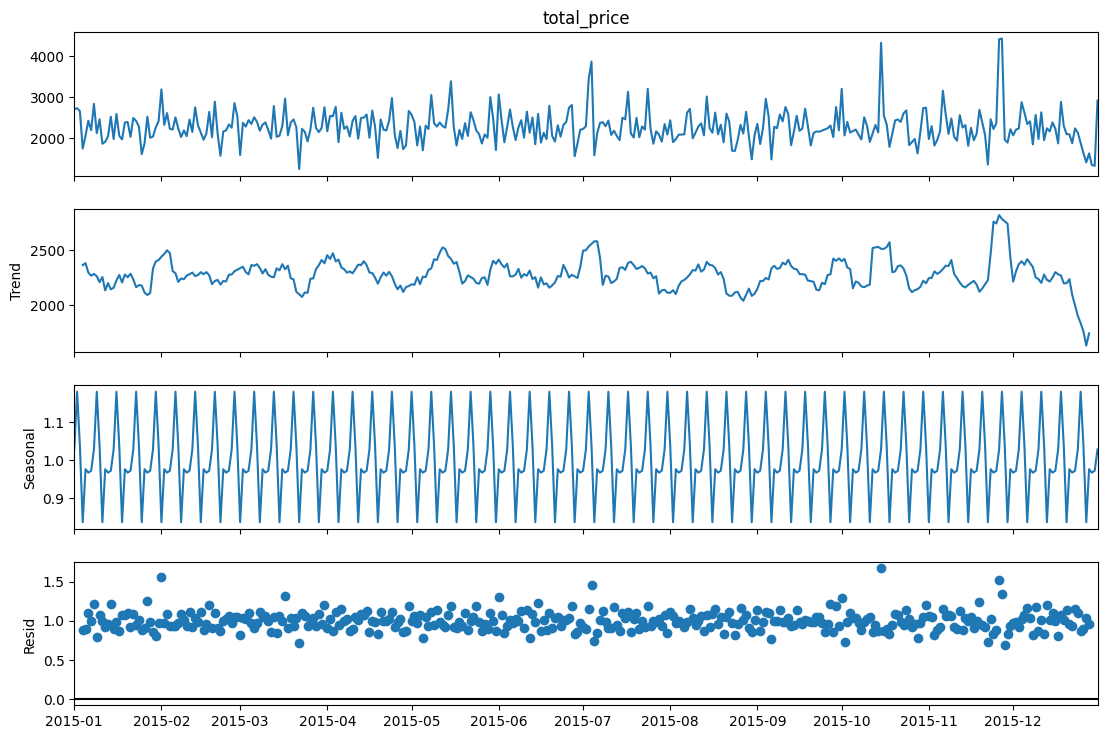

In [14]:
# Apply seasonal decomposition to data downsampled to daily
result = seasonal_decompose(by_days, model='multiplicative', period = 7) # Use 'multiplicative' for multiplicative model, period of 7 for seasonality

# trend = result.trend
# seasonal = result.seasonal
residual = result.resid

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 8)
plt.show()

<Figure size 640x480 with 0 Axes>

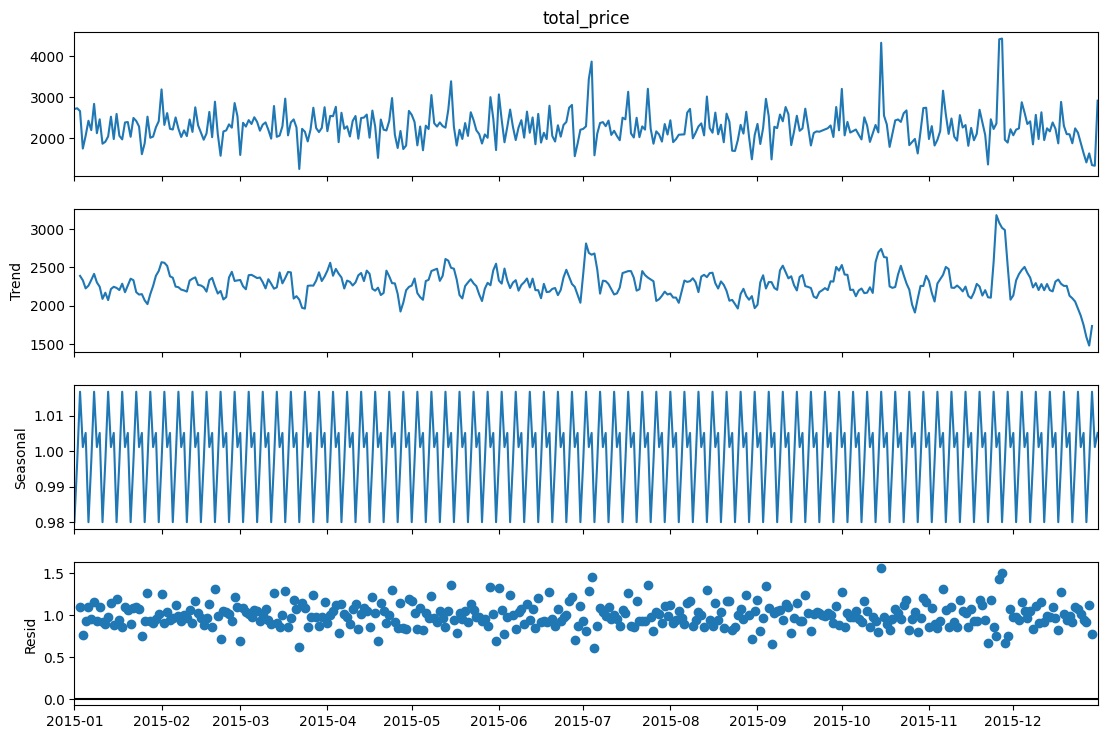

In [15]:
# Same as above with a periodicity of 5 days instead of 7
result = seasonal_decompose(by_days, model='multiplicative', period = 5) # Use 'multiplicative' for multiplicative model, check out period of 5

# trend = result.trend
# seasonal = result.seasonal
residual = result.resid

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 8)
plt.show()

From the seasonal decomposition graph we can pretty clearly see there isn't much trend at all. We will run the Augmented Dickey-Fuller test to confirm this numerically.
### Augmented Dickey-Fuller Test
H0: The time series is non-stationary.

HA: The time series is stationary with.

If the resulting p-value is low, below the significance threshold of 0.05, then we can reject the null hypothesis and embrace the alternate hypothesis.

In [16]:
# Augmented Dickey-Fuller test to statistically test for stationarity
p_value = adfuller(by_days)[1]
p_value

8.371402894907198e-06

The p-value is very close to zero. Therefore we can rejct H0 without fear of committing a Type I error, and conclude that the time series is stationary (has no trend). We will fit a linear model to see just how "unchanging" (i.e. not trending) the sales data is.

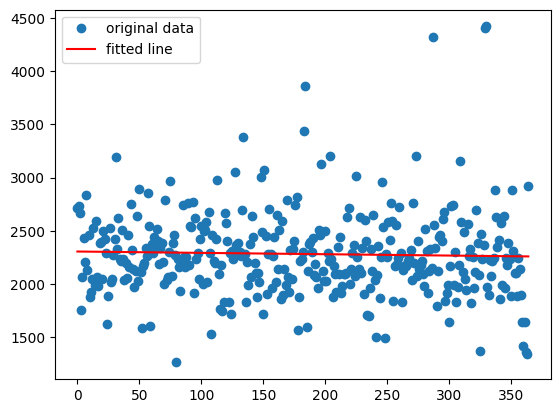

In [17]:
# Need to change index from datetime objects to ordinary numbers for OLS compuatations
for_linear_model = by_days.copy()
for_linear_model.reset_index(inplace = True, drop=True) # The old time series index is replaced by a simple integer index, but the order of the sales is preserved

res = stats.linregress(for_linear_model.index, for_linear_model) # Create linear model object
plt.plot(for_linear_model.index, for_linear_model, 'o', label='original data')
plt.plot(for_linear_model.index, res.intercept + res.slope*for_linear_model.index, 'r', label='fitted line')
plt.legend()
plt.show()

In [18]:
# Look at slope to see how close to zero it is
res.slope

-0.12660641177820617

Now we test for heteroskedasticity (a constant variance throughout). This the last bit in determining the stationarity of your time series. 

# NEEDS WORK

In [19]:
thing = het_arch(residual.dropna())
print('p-value is this:', thing[1])

p-value is this: 3.3679134080283865e-31


# ARIMA Modeling

Having taken a look at our data with rolling averages and standard deviations, the seasonal decomposition plots, the acf and pacf plots, and adfuller test results, we're fairly certain our data is stationary. The decomposition plots, the rolling average plots, and the adfuller test tell us that our data has no trend. The seasonal decomposition and basic time series plots tell us that our data has a high degree of seasonality. The acf and pacf plots tell us that this seasonality comes in 7 day windows. This exploratory data analysis is useful, but by no means deterministic with regards to the correct model order choices. The parameter space is constrained, but not fully determined. Therefore, we will still attempt a grid search for some model orders, while certain others are known. For example, the fact that our daily sales data had no trend means that we did not need to take a difference to achieve stationarity. Therefore, the d parameter of the Autoregressive portion of the ARIMA model will be zero (p, d, q).

In [20]:
# Designate train/test split. Since this is a time series, order matters. Therefore when making our split, we must preserve the order of data points. 
# To do this we simply take the first nine months for our training data and reserve the remaining three months for testing data.
train = by_days.loc[:'2015-08-31']
test = by_days.loc['2015-09-01':]

In [21]:
train.head()

order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
Name: total_price, dtype: float64

# GRIDSEARCH TIME NEEDS WORK

In [22]:
# Custom wrapper for ARIMA model to use with scikit-learn's GridSearchCV
class ARIMAWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None

    def fit(self, X, y):
        self.model = ARIMA(endog=y, order=self.order, seasonal_order=self.seasonal_order)
        self.model_fit = self.model.fit()
        return self

    def predict(self, X):
        return self.model_fit.forecast(steps=len(X))

In [23]:
# Create a smaller parameter grid
param_grid = {
    'order': [(p, d, q) for p in range(1, 84, 7) for d in range (0, 2) for q in range(1, 3)],
    'seasonal_order': [(P, D, Q, S) for P in range(1, 3) for D in range(0, 3) for Q in range(1, 3) for S in range(0, 8)]
}

# Initialize the GridSearchCV
grid = GridSearchCV(estimator=ARIMAWrapper(), param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Fit to the data
grid.fit(train.index, train)

# Summary of the best model
print(f'Best ARIMA{grid.best_params_["order"]}x{grid.best_params_["seasonal_order"]} model - MSE:{-grid.best_score_}')

# Predicting and calculating MSE
y_pred = grid.best_estimator_.predict(test)
mae = mean_absolute_error(test, y_pred)
rmse = sqrt(mean_squared_error(test, y_pred))

print(f'Mean Absolute Error (MSE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Fitting 3 folds for each of 4608 candidates, totalling 13824 fits


Best ARIMA(1, 0, 2)x(1, 0, 2, 7) model - MSE:109931.06481033076
Mean Absolute Error (MSE): 273.1777686062062
Root Mean Squared Error (RMSE): 433.22175424990473


In [24]:
# Create and fit the ARIMA model
# A first pass, using all 1's for model orders except for seasonality (7)
model = ARIMA(endog=train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7), freq = 'D')
results = model.fit()

In [25]:
# # Model summary
# print(results.summary())

In [26]:
# # Model diagnostics
# results.plot_diagnostics()

In [27]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions = results.predict(start = test.index[0], end = test.index[-1])
predictions.sample(5)

2015-12-20    1849.895344
2015-12-09    2202.116161
2015-11-12    2216.082234
2015-12-08    2139.411196
2015-10-02    2706.424828
Name: predicted_mean, dtype: float64

In [28]:
# # Visually inspect the ARIMA model's predictions against the holdout set
# first_forecast = pd.concat([test, predictions], axis = 1) # Assemble test set and forecast into one dataframe
# first_forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
# first_forecast.plot()
# plt.title('ARIMA Model Sales Forecast vs. Recorded Sales')
# plt.xlabel('Time (Day)')
# plt.ylabel('Sales ($)')
# plt.show()

In [29]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)

scoring_dict = {}
scoring_dict = {'model 1': [model.order +  model.seasonal_order, rmse.round(2), mae.round(2)]}
scoring_dict

{'model 1': [(1, 1, 1, 1, 1, 1, 7), 435.51, 267.49]}

### Begin Fiddling with ARIMA model orders

Start with changing differencing order to 0

In [30]:
# Create and fit the ARIMA model
# A second pass, using all 1's for model orders except for seasonality (7) and a differencing of 0 (d = 0). This was divined through adfuller test above.
model2 = ARIMA(endog=train, order=(1, 0, 1), seasonal_order=(1, 1, 1, 7), freq = 'D')
results2 = model2.fit()

In [31]:
# # Model summary
# print(results2.summary())

In [32]:
# # Model diagnostics
# results2.plot_diagnostics()

In [33]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions2 = results2.predict(start = test.index[0], end = test.index[-1])
predictions2.sample(5)

2015-10-15    2248.403578
2015-11-23    2230.632964
2015-11-16    2231.151814
2015-12-02    2235.158210
2015-09-24    2247.882848
Name: predicted_mean, dtype: float64

In [34]:
# # Visually inspect the ARIMA model's predictions against the holdout set
# first_forecast = pd.concat([test, predictions2], axis = 1) # Assemble test set and forecast into one dataframe
# first_forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
# first_forecast.plot()
# plt.title('ARIMA Model Sales Forecast vs. Recorded Sales')
# plt.xlabel('Time (Day)')
# plt.ylabel('Sales ($)')
# plt.show()

In [35]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test, predictions2))
mae = mean_absolute_error(test, predictions2)
print('Out of the box ARIMA model error metrics ($):')
print('Root mean squared error:', rmse.round(2), 'Mean absolute error', mae.round(2))

scoring_dict['model 2'] =  [model2.order +  model2.seasonal_order, rmse.round(2), mae.round(2)]
scoring_dict

Out of the box ARIMA model error metrics ($):
Root mean squared error: 434.27 Mean absolute error 269.27


{'model 1': [(1, 1, 1, 1, 1, 1, 7), 435.51, 267.49],
 'model 2': [(1, 0, 1, 1, 1, 1, 7), 434.27, 269.27]}

Now try fiddling with p

In [36]:
# Create and fit the ARIMA model
model3 = ARIMA(endog=train, order=(1, 0, 1), seasonal_order=(2, 1, 1, 7), freq = 'D')
results3 = model3.fit()

In [37]:
# # Model summary
# print(results3.summary())

In [38]:
# # Model diagnostics
# results3.plot_diagnostics()

In [39]:
# Create and store predictions for the beginning of the range of dates contained in the test set (September 1st through December 31st)
predictions2 = results2.predict(start = test.index[0], end = test.index[-1])
predictions2.sample(5)

2015-11-18    2235.158487
2015-12-03    2247.884290
2015-09-02    2237.032711
2015-09-30    2234.638606
2015-10-05    2231.152646
Name: predicted_mean, dtype: float64

In [40]:
# # Visually inspect the ARIMA model's predictions against the holdout set
# first_forecast = pd.concat([test, predictions2], axis = 1) # Assemble test set and forecast into one dataframe
# first_forecast.rename(columns = {'total_price': 'recorded_sales', 'predicted_mean': 'forecast'}, inplace = True) # rename columns to be more intuitive
# first_forecast.plot()
# plt.title('ARIMA Model Sales Forecast vs. Recorded Sales')
# plt.xlabel('Time (Day)')
# plt.ylabel('Sales ($)')
# plt.show()

In [41]:
# Obtain and inspect two error metrics: Root Mean Squared Error and Mean Absolute Error
rmse = np.sqrt(mean_squared_error(test, predictions2))
mae = mean_absolute_error(test, predictions2)
print('Out of the box ARIMA model error metrics ($):')
print('Root mean squared error:', rmse.round(2), 'Mean absolute error', mae.round(2))

scoring_dict['model 2'] =  [model2.order +  model2.seasonal_order, rmse.round(2), mae.round(2)]
scoring_dict

Out of the box ARIMA model error metrics ($):
Root mean squared error: 434.27 Mean absolute error 269.27


{'model 1': [(1, 1, 1, 1, 1, 1, 7), 435.51, 267.49],
 'model 2': [(1, 0, 1, 1, 1, 1, 7), 434.27, 269.27]}

### Baseline Comparison
Your model's performance means only so much on its own. Often we find ourselves needing to know how well our model has done *compared to* the current model, or compared to some baseline. Here we explore different baselines and see what their error metrics are like.

In [42]:
# Generating Seasonal Naive Forecast
seasonal_naive_forecast = test.shift(7)

# Remove NaN values produced by the shift operation
seasonal_naive_forecast.dropna(inplace=True)

In [43]:
rmse = np.sqrt(mean_squared_error(test[7:], seasonal_naive_forecast))
mae = mean_absolute_error(test[7:], seasonal_naive_forecast)
rmse, mae

(580.5303153526767, 370.5682608695652)

In [44]:
noise = np.random.uniform(-455, 455, size = len(seasonal_naive_forecast))
noisy_seasonal_naive_forecast = seasonal_naive_forecast + noise

rmse = np.sqrt(mean_squared_error(test[7:], noisy_seasonal_naive_forecast))
mae = mean_absolute_error(test[7:], noisy_seasonal_naive_forecast)
rmse, mae

(594.7797862991912, 419.4321789906989)

In [45]:
# Calculate residuals
residuals = test[7:] - seasonal_naive_forecast

# Determine their standard deviation
natural_variability = residuals.std()

In [46]:
natural_variability

582.2469550285081

In [47]:
noise = np.random.uniform(-natural_variability, natural_variability, size = len(seasonal_naive_forecast))
noisy_seasonal_naive_forecast = seasonal_naive_forecast + noise

rmse = np.sqrt(mean_squared_error(test[7:], noisy_seasonal_naive_forecast))
mae = mean_absolute_error(test[7:], noisy_seasonal_naive_forecast)
rmse, mae

(690.0811449000284, 508.71055682678383)

In [48]:
(568.8026191083292, 367.2661815068493)

(568.8026191083292, 367.2661815068493)

In [49]:
noise_dates = []
us_holidays = holidays.UnitedStates(years=2015)
for date, name in sorted(us_holidays.items()):
    print(f"{date}: {name}")
    noise_dates.append(date)

2015-01-01: New Year's Day
2015-01-19: Martin Luther King Jr. Day
2015-02-16: Washington's Birthday
2015-05-25: Memorial Day
2015-07-03: Independence Day (Observed)
2015-07-04: Independence Day
2015-09-07: Labor Day
2015-10-12: Columbus Day
2015-11-11: Veterans Day
2015-11-26: Thanksgiving
2015-12-25: Christmas Day


In [50]:
dummy_model = seasonal_naive_forecast.copy()

In [51]:
def boost_sales_on_holidays(data, holiday_list, coefficient):
    # Filter holidays from September onward
    holiday_list = [date for date in holiday_list if date >= datetime.date(2015, 9, 1)]
    
    # Convert the list to a Pandas datetime format for easier comparison
    holiday_list = pd.to_datetime(holiday_list)
    
    # Boost the 'sales' column by 50% where the date matches a holiday
    data.loc[data.index.isin(holiday_list)] *= 1.5

In [52]:
# Apply the boost to the DataFrame
boost_sales_on_holidays(dummy_model, noise_dates, 1.5)

In [53]:
dummy_model, seasonal_naive_forecast

(order_date
 2015-09-08    2352.85
 2015-09-09    1865.55
 2015-09-10    2252.60
 2015-09-11    2960.95
 2015-09-12    2537.80
                ...   
 2015-12-27    2104.90
 2015-12-28    2100.70
 2015-12-29    1882.95
 2015-12-30    2244.30
 2015-12-31    2137.85
 Name: total_price, Length: 115, dtype: float64,
 order_date
 2015-09-08    2352.85
 2015-09-09    1865.55
 2015-09-10    2252.60
 2015-09-11    2960.95
 2015-09-12    2537.80
                ...   
 2015-12-27    2104.90
 2015-12-28    2100.70
 2015-12-29    1882.95
 2015-12-30    2244.30
 2015-12-31    2137.85
 Name: total_price, Length: 115, dtype: float64)

<Axes: xlabel='order_date'>

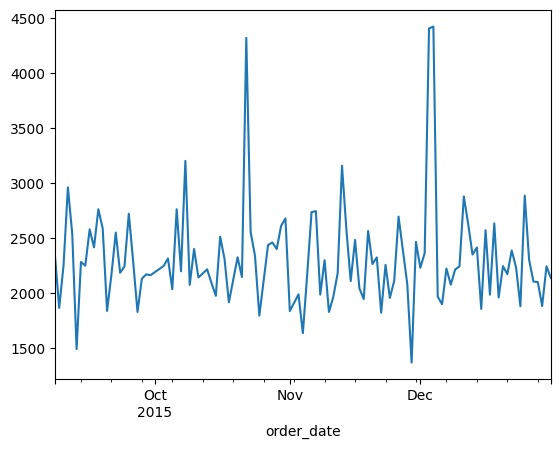

In [54]:
seasonal_naive_forecast.plot()

<Axes: xlabel='order_date'>

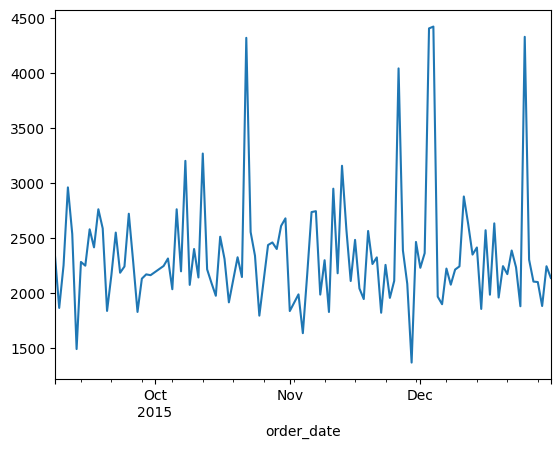

In [55]:
dummy_model.plot()

<Axes: xlabel='order_date'>

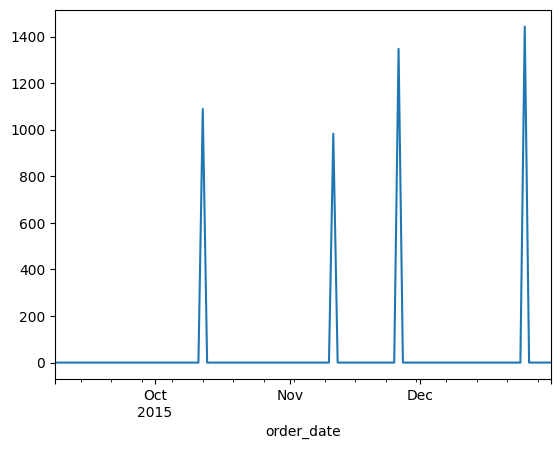

In [56]:
difference = dummy_model - seasonal_naive_forecast
difference.plot()

In [57]:
rmse = np.sqrt(mean_squared_error(test[7:], dummy_model))
mae = mean_absolute_error(test[7:], dummy_model)
rmse, mae

(613.1687445913645, 389.42293478260865)

### Exploring Hourly Sales as Timeseries

In [58]:
# Join date and time columns for combined datetime column
df['complete_order_date'] = pd.to_datetime(df['order_date'].astype(str)+' '+df['order_time'].astype(str))

NameError: name 'df' is not defined

In [ ]:
# Create hourly downsampled sales from complete datetime column
hourly_sales = df[['complete_order_date', 'total_price']]
hourly_sales.set_index('complete_order_date', inplace = True)
hourly_sales = hourly_sales.resample('1H').sum()

In [ ]:
hourly_sales

,total_price
complete_order_date,
2015-01-01 11:00:00,105.25
2015-01-01 12:00:00,263.25
2015-01-01 13:00:00,577.20
2015-01-01 14:00:00,246.00
2015-01-01 15:00:00,230.25
...,...
2015-12-31 19:00:00,396.15
2015-12-31 20:00:00,278.50
2015-12-31 21:00:00,113.20


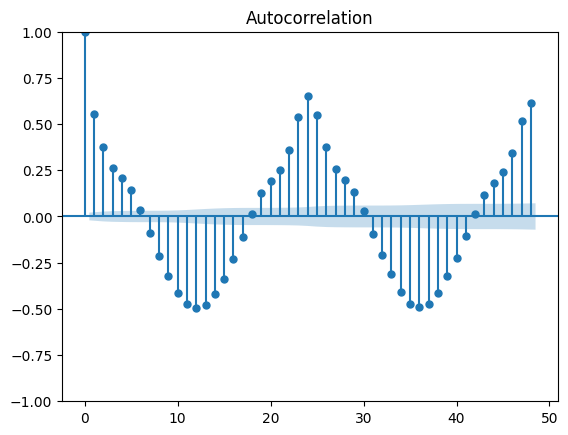

In [ ]:
# Autocorrelation for data downsampled to daily
plot_acf(hourly_sales, lags = 48)
plt.show()

In [ ]:
# # Apply seasonal decomposition
# result = seasonal_decompose(by_days, model='additive') # Use 'multiplicative' for multiplicative model

# # # You can then access the individual components
# # trend = result.trend
# # seasonal = result.seasonal
# # residual = result.resid

# fig = plt.figure()  
# fig = result.plot()  
# fig.set_size_inches(15, 8)
# plt.show()